# Fitting a Straight Line

_Phil Marshall, Daniel Foreman-Mackey and Dustin Lang_

_Astro Hack Week, New York, September 2015_ 

### Goals:

* Set up and carry out a simple Bayesian inference, characterizing a simple posterior PDF


* Compare brute force, analytic and MCMC sampled results


* Check models, with posterior predictive distributions of test statistics


* Use the Bayesian Evidence to compare various models, and understand its properties


* Suggest some simple hacks to get some practice with Bayesian inference

In [2]:
%load_ext autoreload
%autoreload 2

from __future__ import print_function
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['figure.figsize'] = (8.0, 8.0)
plt.rcParams['savefig.dpi'] = 100

In [3]:
from straightline_utils import *

## The Data

* Let's generate a simple dataset: observations of $y$ with reported uncertainties $\sigma_y$, at given $x$ values.

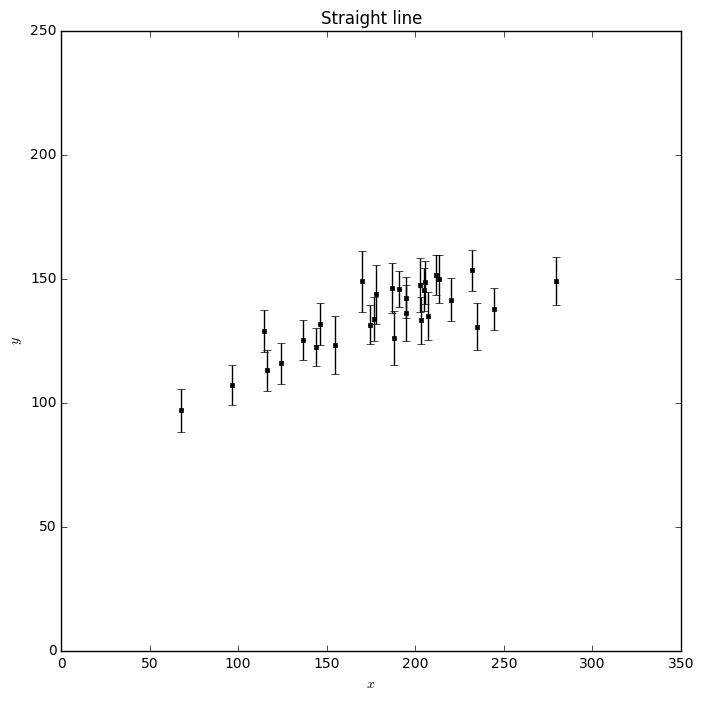

In [4]:
(x,y,sigmay) = generate_data()

plot_yerr(x, y, sigmay)

## Least squares fitting

* An industry standard: find the slope and intercept that minimize the mean square residual. Since the data depend linearly on the parameters, the least squares solution can be found by a matrix inversion and multiplication, conveneniently packed in `numpy.linalg`.


* Suppose that the $y$ values are related to the $x$ values by $y = m x + b$, where $x$ and $y$ are "vectors" (`numpy` arrays). We want to find $m$ and $b$ that minimize

$\chi^2 = \sum_k \frac{(y_k - m x_k - b)^2}{\sigma_k^2}$


* Here, $1/\sigma_k^2$ is a sensible weighting factor that reduces the influence of $y_k$ values with large uncertainty $\sigma_k$


* Differentiating $\chi^2$ with respect to $m$ and $b$ and setting the result to zero leads to a matrix equation that can be solved - this is what `np.linalg.lstsq` is doing.

Least Squares (maximum likelihood) estimator: 89.3641005525 0.250919464805


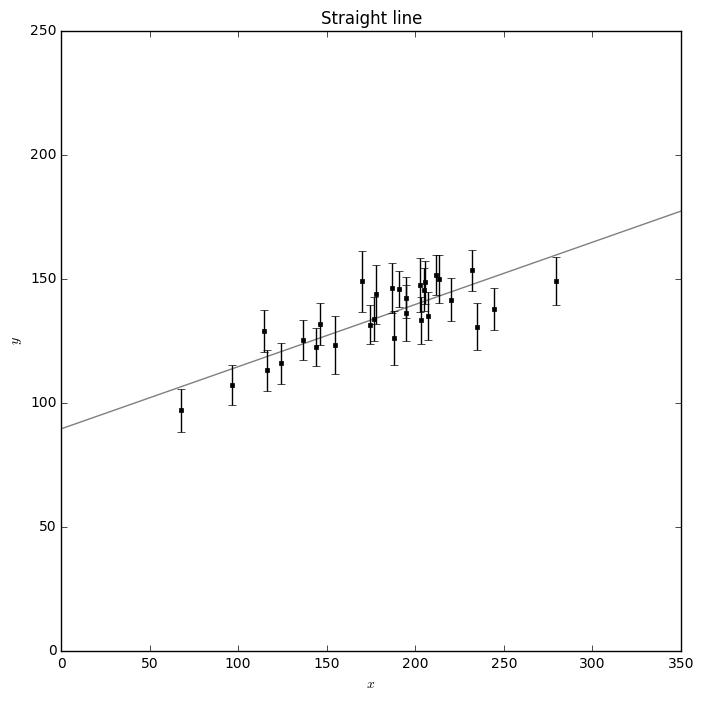

In [5]:
# Linear algebra: weighted least squares
N = len(x)
A = np.zeros((N,2))
A[:,0] = 1. / sigmay
A[:,1] =  x / sigmay
b = y / sigmay
theta,nil,nil,nil = np.linalg.lstsq(A, b)
plot_yerr(x, y, sigmay)
b_ls,m_ls = theta
print('Least Squares (maximum likelihood) estimator:', b_ls,m_ls)
plot_line(m_ls, b_ls);

# Probabilistic Fitting

* Ref to this morning!

## Evaluating posterior probability on a grid

This procedure will get us the Bayesian solution to the problem - not an estimator, but a probability distribution for the parameters m and b. This PDF captures the uncertainty in the model parameters given the data. For simple, 2-dimensional parameter spaces like this one, evaluating on a grid is not a bad way to go. We'll see that the least squares solution lies at the peak of the posterior PDF - for a certain set of assumptions about the data and the model.

In [ ]:
def straight_line_log_likelihood(x, y, sigmay, m, b):
    '''
    Returns the log-likelihood of drawing data values *y* at
    known values *x* given Gaussian measurement noise with standard
    deviation with known *sigmay*, where the "true" y values are
    *y_t = m * x + b*

    x: list of x coordinates
    y: list of y coordinates
    sigmay: list of y uncertainties
    m: scalar slope
    b: scalar line intercept

    Returns: scalar log likelihood
    '''
    return (np.sum(np.log(1./(np.sqrt(2.*np.pi) * sigmay))) +
            np.sum(-0.5 * (y - (m*x + b))**2 / sigmay**2))


def straight_line_log_prior(m, b, mlimits, blimits):
    # Uniform in m:
    if (m < mlimits[0]) | (m > mlimits[1]):
        log_m_prior = -np.inf
    else:
        log_m_prior = -np.log(mlimits[1] - mlimits[0])
    # Uniform in b:
    if (b < blimits[0]) | (b > blimits[1]):
        log_b_prior = -np.inf
    else:
        log_b_prior = -np.log(blimits[1] - blimits[0])
        
    return log_m_prior + log_b_prior


def straight_line_log_posterior(x,y,sigmay,m,b,mlimits,blimits):
    return (straight_line_log_likelihood(x,y,sigmay,m,b) +
            straight_line_log_prior(m,b,mlimits,blimits))

In [ ]:
# Evaluate log P(m,b | x,y,sigmay) on a grid.

# Define uniform prior limits, enforcing positivity in both parameters:
mlimits = [0.0, 2.0]
blimits = [0.0, 200.0]

# Set up grid:
mgrid = np.linspace(mlimits[0], mlimits[1], 101)
bgrid = np.linspace(blimits[0], blimits[1], 101)
log_posterior = np.zeros((len(mgrid),len(bgrid)))

# Evaluate log posterior PDF:
for im,m in enumerate(mgrid):
    for ib,b in enumerate(bgrid):
        log_posterior[im,ib] = straight_line_log_posterior(x, y, sigmay, m, b, mlimits, blimits)

# Convert to probability density and plot

posterior = np.exp(log_posterior - log_posterior.max())

plt.imshow(posterior, extent=[blimits[0],blimits[1],mlimits[0],mlimits[1]],cmap='Blues',
           interpolation='none', origin='lower', aspect=(blimits[1]-blimits[0])/(mlimits[1]-mlimits[0]),
           vmin=0, vmax=1)
plt.contour(bgrid, mgrid, posterior, pdf_contour_levels(posterior), colors='k')

i = np.argmax(posterior)
i,j = np.unravel_index(i, posterior.shape)
print('Grid maximum posterior values (m,b) =', mgrid[i], bgrid[j])

plt.title('Straight line: posterior PDF for parameters');
plt.plot(b_ls, m_ls, 'r+', ms=12, mew=4);
plot_mb_setup(mlimits,blimits);

## MCMC Sampling

In problems with higher dimensional parameter spaces, we need a more efficient way of approximating the posterior PDF - both when characterizing it in the first place, and then when doing integrals over that PDF (to get the marginalized PDFs for the parameters, or to compress them in to single numbers with uncertainties that can be easily reported). In most applications it's sufficient to approximate a PDF with a (relatively) small number of samples drawn from it; MCMC is a procedure for drawing samples from PDFs.  

In [ ]:
def straight_line_posterior(x, y, sigmay, m, b, mlimits, blimits):
    return np.exp(straight_line_log_posterior(x, y, sigmay, m, b, mlimits, blimits))

In [ ]:
# initial m, b, at center of ranges
m,b = 0.5*(mlimits[0]+mlimits[1]), 0.5*(blimits[0]+blimits[1])

# step sizes, 5% of the prior
mstep, bstep = 0.05*(mlimits[1]-mlimits[0]), 0.1*(blimits[1]-blimits[0])
        
# how many steps?
nsteps = 10000
    
chain = []
probs = []
naccept = 0
    
print('Running MH for', nsteps, 'steps')

# First point:
L_old    = straight_line_log_likelihood(x, y, sigmay, m, b)
p_old    = straight_line_log_prior(m, b, mlimits, blimits)
logprob_old = L_old + p_old

for i in range(nsteps):
    # step
    mnew = m + np.random.normal() * mstep
    bnew = b + np.random.normal() * bstep

    # evaluate probabilities
    L_new    = straight_line_log_likelihood(x, y, sigmay, mnew, bnew)
    p_new    = straight_line_log_prior(mnew, bnew, mlimits, blimits)
    logprob_new = L_new + p_new

    if (np.exp(logprob_new - logprob_old) > np.random.uniform()):
        # Accept the new sample:
        m = mnew
        b = bnew
        L_old = L_new
        p_old = p_new
        logprob_old = logprob_new
        naccept += 1
    else:
        # Stay where we are; m,b stay the same, and we append them
        # to the chain below.
        pass

    chain.append((b,m))
    probs.append((L_old,p_old))
    
print('Acceptance fraction:', naccept/float(nsteps))

In [ ]:
# Pull m and b arrays out of the Markov chain and plot them:
mm = [m for b,m in chain]
bb = [b for b,m in chain]

# Traces, for convergence inspection:
plt.figure(figsize=(8,5))
plt.subplot(2,1,1)
plt.plot(mm, 'k-')
plt.ylim(mlimits)
plt.ylabel('m')
plt.subplot(2,1,2)
plt.plot(bb, 'k-')
plt.ylabel('Intercept b')
plt.ylim(blimits)

* This looks pretty good: no plateauing, or drift.


* A more rigorous test for convergence is due to Gelman & Rubin, and involves comparing the intrachain variance with the inter-chain variance in an ensemble. It's worth reading up on. 


* Foreman-Mackey & Hogg recommend looking at the autocorrelation length, and whther it stablizes during the run.

In [ ]:
# Look at samples in parameter space.

# First show contours from gridding calculation:
plt.contour(bgrid, mgrid, posterior, pdf_contour_levels(posterior), colors='k')
plt.gca().set_aspect((blimits[1]-blimits[0])/(mlimits[1]-mlimits[0]))

# Scatterplot of m,b posterior samples, overlaid:
plt.plot(bb, mm, 'b.', alpha=0.1)
plot_mb_setup(mlimits,blimits)

In [ ]:
# 1 and 2D marginalised distributions:

!pip install --upgrade --no-deps corner

In [ ]:
import corner
corner.corner(chain, labels=['b','m'], range=[blimits,mlimits],quantiles=[0.16,0.5,0.84],
                show_titles=True, title_args={"fontsize": 12},
                plot_datapoints=True, fill_contours=True, levels=[0.68, 0.95], 
                color='b', bins=80, smooth=1.0);

Looks like a measurement - but let's do some checks first.

## Model Checking

How do we know if our model is any good? There are two properties that "good" models have: the first is accuracy, and the second is efficiency. Accurate models generate data that is *like* the observed data. What does this mean? First we have to define what similarity is, in this context. Visual impression is one very important way. Test statistics that capture relevant features of the data are another. Let's look at the posterior predictive distributions for the datapoints, and for a particularly interesting test statistic, the reduced chi-squared.

In [ ]:
# Posterior visual check, in data space
X = np.array(xlimits)
for i in (np.random.rand(100)*len(chain)).astype(int):
    b,m = chain[i]
    plt.plot(X, b+X*m, 'b-', alpha=0.1)
plot_line(m_ls, b_ls);
plot_yerr(x, y, sigmay)

In [ ]:
# Test statistics: functions of the data, not the parameters.

# 1) Reduced chisq for the best fit model:
def test_statistic(x,y,sigmay,b_ls,m_ls):
  return np.sum((y - m_ls*x - b_ls)**2.0/sigmay**2.0)/(len(y)-2)

# 2) Reduced chisq for the best fit m=0 model:
# def test_statistic(x,y,sigmay,dummy1,dummy2):
#    return np.sum((y - np.mean(y))**2.0/sigmay**2.0)/(len(y)-1)

# 3) Weighted mean y:
# def test_statistic(x,y,sigmay,dummy1,dummy2):
#    return np.sum(y/sigmay**2.0)/np.sum(1.0/sigmay**2.0)

# 4) Variance of y:
# def test_statistic(x,y,sigmay,dummy1,dummy2):
#    return np.var(y)


# Approximate the posterior predictive distribution for T, 
# by drawing a replica dataset for each sample (m,b) and computing its T:
T = np.zeros(len(chain))
for k,(b,m) in enumerate(chain):
    yrep = b + m*x + np.random.randn(len(x)) * sigmay
    T[k] = test_statistic(x,yrep,sigmay,b_ls,m_ls)
    
# Compare with the test statistic of the data, on a plot:   
Td = test_statistic(x,y, sigmay, b_ls, m_ls)

plt.hist(T, 100, histtype='step', color='blue', lw=2, range=(0.0,np.percentile(T,99.0)))
plt.axvline(Td, color='black', linestyle='--', lw=2)
plt.xlabel('Test statistic')
plt.ylabel('Posterior predictive distribution')


# What is Pr(T>T(d)|d)?

greater = (T > Td)
P = 100*len(T[greater])/(1.0*len(T))
print("Pr(T>T(d)|d) = ",P,"%")

* If our model is true (and we're just uncertain about its parameters, given the data), we can compute the probability of getting a $T$ less than that observed, where T is the reduced chisq relative to a straight line with some reference $(m,b)$.


* Note that we did not have to look up the "chi squared distribution" - we can simply compute the posterior predictive distribution given our generative model.


* Still, this test statistic looks a little bit strange: it's computed relative to the best fit straight line - which is a sensible reference but somehow not really in the spirit of fitting the data...

* Instead, lets look at a *discrepancy* $T(d,\theta)$ that is a function of both the data and the parameters, and compute the posterior probability of getting $T(d^{\rm rep},\theta) > T(d,\theta)$

${\rm Pr}(T[d^{\rm rep},\theta] > T[d,\theta]|d) = {\rm Pr}(T[d^{\rm rep},\theta] > T[d,\theta]|\theta,d)\;{\rm Pr}(\theta|d)\;d\theta$

In [ ]:
# Discrepancy: functions of the data AND parameters.

# 1) Reduced chisq for the model:
def test_statistic(x,y,sigmay,b,m):
   return np.sum((y - m*x - b)**2.0/sigmay**2.0)/(len(y)-2)

# Approximate the posterior predictive distribution for T, 
# by drawing a replica dataset for each sample (m,b) and computing its T, 
# AND ALSO its Td:
T = np.zeros(len(chain))
Td = np.zeros(len(chain))
for k,(b,m) in enumerate(chain):
    yrep = b + m*x + np.random.randn(len(x)) * sigmay
    T[k] = test_statistic(x,yrep,sigmay,b,m)
    Td[k] = test_statistic(x,y,sigmay,b,m)
    
# Compare T with Td, on a scatter plot:   

plt.scatter(Td, T, color='blue',alpha=0.1)
plt.plot([0.0, 100.0], [0.0, 100.], color='k', linestyle='--', linewidth=2)
plt.xlabel('Observed discrepancy $T(d,\\theta)$')
plt.ylabel('Replicated discrepancy $T(d^{\\rm rep},\\theta)$')
plt.ylim([0.0,np.percentile(Td,99.0)])
plt.xlim([0.0,np.percentile(Td,99.0)])


In [ ]:
# Histogram of differences:

diff = T-Td
plt.hist(diff, 100, histtype='step', color='blue', lw=2, range=(np.percentile(diff,1.0),np.percentile(diff,99.0)))
plt.axvline(0.0, color='black', linestyle='--', lw=2)
plt.xlabel('Difference $T(d^{\\rm rep},\\theta) - T(d,\\theta)$')
plt.ylabel('Posterior predictive distribution')


# What is Pr(T>T(d)|d)?

greater = (T > Td)
Pline = 100*len(T[greater])/(1.0*len(T))
print("Pr(T>T(d)|d) = ",Pline,"%")

* The conclusion drawn from the discrepancy is more conservative. All our $\theta = (m,b)$ samples are plausible, so replica datasets generated by them should also be plausible: the straight line defined by each $(m,b)$ should go through the real data points as readily (on average) as it does its replica dataset.


* Do our posterior predictive $p-$values suggest we need to improve our model? What about the visual check?

## Higher order polynomial?

* Maybe I see some curvature in the data. Let's try adding an extra parameter to the model, to see if our data are better modeled using a quadratic function than a straight line. 


$y = m x + b + q*x**2$

* The coefficient $q$ is probably pretty small (we were expecting to only have to use a straight line model for these data!), so we can assign a fairly narrow prior.

In [ ]:
def quadratic_log_likelihood(x, y, sigmay, m, b, q):
    '''
    Returns the log-likelihood of drawing data values y at
    known values x given Gaussian measurement noise with standard
    deviation with known sigmay, where the "true" y values are
    y_t = m*x + b + q**2

    x: list of x coordinates
    y: list of y coordinates
    sigmay: list of y uncertainties
    m: scalar slope
    b: scalar line intercept
    q: quadratic term coefficient

    Returns: scalar log likelihood
    '''
    return (np.sum(np.log(1./(np.sqrt(2.*np.pi) * sigmay))) +
            np.sum(-0.5 * (y - (m*x + b + q*x**2))**2 / sigmay**2))
    
    
def quadratic_log_prior(m, b, q, mlimits, blimits, qpars):
    # m and b:
    log_mb_prior = straight_line_log_prior(m, b, mlimits, blimits)
    # q:
    log_q_prior = np.log(1./(np.sqrt(2.*np.pi) * qpars[1])) - \
                  0.5 * (q - qpars[0])**2 / qpars[1]**2
    return log_mb_prior + log_q_prior
    
    
def quadratic_log_posterior(x,y,sigmay,m,b,q):
    return (quadratic_log_likelihood(x,y,sigmay,m,b,q) +
            quadratic_log_prior(m,b,q))

In [ ]:
# Assign Gaussian prior for q:
qpars = [0.0,0.003]

# initial m, b, q, at center of ranges
m,b,q = 0.5, 50, 0.0

# step sizes
mstep, bstep, qstep = 0.05, 5.0, 0.0003
        
# how many steps?
nsteps = 10000
    
chain = []
probs = []
naccept = 0
    
print('Running MH for', nsteps, 'steps')

# First point:
L_old    = quadratic_log_likelihood(x, y, sigmay, m, b, q)
p_old    = quadratic_log_prior(m, b, q, mlimits, blimits, qpars)
logprob_old = L_old + p_old

for i in range(nsteps):
    # step
    mnew = m + np.random.normal() * mstep
    bnew = b + np.random.normal() * bstep
    qnew = q + np.random.normal() * qstep

    # evaluate probabilities
    L_new    = quadratic_log_likelihood(x, y, sigmay, mnew, bnew, qnew)
    p_new    = quadratic_log_prior(mnew, bnew, qnew, mlimits, blimits, qpars)
    logprob_new = L_new + p_new

    if (np.exp(logprob_new - logprob_old) > np.random.uniform()):
        # Accept the new sample:
        m = mnew
        b = bnew
        q = qnew
        L_old = L_new
        p_old = p_new
        logprob_old = logprob_new
        naccept += 1
    else:
        # Stay where we are; m,b stay the same, and we append them
        # to the chain below.
        pass

    chain.append((b,m,q))
    probs.append((L_old,p_old))
    
print('Acceptance fraction:', naccept/float(nsteps))

In [ ]:
# Pull m, b and q arrays out of the Markov chain and plot them:
mm = [m for b,m,q in chain]
bb = [b for b,m,q in chain]
qq = [q for b,m,q in chain]

# Traces, for convergence inspection:
plt.figure(figsize=(8,5))
plt.subplot(3,1,1)
plt.plot(mm, 'k-')
plt.ylim(mlimits)
plt.ylabel('m')
plt.subplot(3,1,2)
plt.plot(bb, 'k-')
plt.ylim(blimits)
plt.ylabel('Intercept b')
plt.subplot(3,1,3)
plt.plot(qq, 'k-')
plt.ylim([qpars[0]-3*qpars[1],qpars[0]+3*qpars[1]])
plt.ylabel('Quadratic coefficient q')

In [ ]:
corner.corner(chain, labels=['b','m','q'], range=[blimits,mlimits,(qpars[0]-3*qpars[1],qpars[0]+3*qpars[1])],quantiles=[0.16,0.5,0.84],
                show_titles=True, title_args={"fontsize": 12},
                plot_datapoints=True, fill_contours=True, levels=[0.68, 0.95], 
                color='green', bins=80, smooth=1.0);
plt.show()

### Checking the Quadratic Model

In [ ]:
# Posterior visual check, in data space
X = np.linspace(xlimits[0],xlimits[1],100)
for i in (np.random.rand(100)*len(chain)).astype(int):
    b,m,q = chain[i]
    plt.plot(X, b + X*m + q*X**2, 'g-', alpha=0.1)
plot_line(m_ls, b_ls);
plot_yerr(x, y, sigmay)

In [ ]:
# Discrepancy: functions of the data AND parameters.

# 1) Reduced chisq for the model:
def test_statistic(x,y,sigmay,b,m,q):
   return np.sum((y - m*x - b - q*x**2)**2.0/sigmay**2.0)/(len(y)-3)

# Approximate the posterior predictive distribution for T, 
# by drawing a replica dataset for each sample (m,b) and computing its T, 
# AND ALSO its Td:
T = np.zeros(len(chain))
Td = np.zeros(len(chain))
for k,(b,m,q) in enumerate(chain):
    yp = b + m*x + q*x**2 + sigmay*np.random.randn(len(x))
    T[k] = test_statistic(x,yp,sigmay,b,m,q)
    Td[k] = test_statistic(x,y,sigmay,b,m,q)

# Histogram of differences:
diff = T - Td
plt.hist(diff, 100, histtype='step', color='green', lw=2, range=(np.percentile(diff,1.0),np.percentile(diff,99.0)))
plt.axvline(0.0, color='black', linestyle='--', lw=2)
plt.xlabel('Difference $T(d^{\\rm rep},\\theta) - T(d,\\theta)$')
plt.ylabel('Posterior predictive distribution')

# What is Pr(T>T(d)|d)?
greater = (T > Td)
Pquad = 100*len(T[greater])/(1.0*len(T))
print("Pr(T>T(d)|d,quadratic) = ",Pquad,"%, cf. Pr(T>T(d)|d,straightline) = ",Pline,"%")

* This model checks out too: both the quadratic and linear models provide reasonable fits to the data, with the posterior predictive replica datasets behaving acceptably similarly to the real data.


* But, the predictions seem comparably precise! Which model should we prefer?

## Model Comparison with the Bayesian Evidence

* The evidence for model $H$, ${\rm Pr}(d|H)$, enables a form of Bayesian hypothesis testing via the evidence ratio (or "odds ratio", or "Bayes Factor"):

$R = \frac{{\rm Pr}(d|H_1)}{{\rm Pr}(d|H_0)}$


* This quantity is similar to a likelihood ratio, but its a *fully marginalized likelihood ratio* - which is to say that it *takes into account our uncertainty about values of the parameters of each model* by integrating over them all.


* As well predictive accuracy, the other virtue a model can have is *efficiency*. The evidence *summarizes all the information we put into our model inferences*, via both the data and our prior beliefs.  You can see this by inspection of the integrand of the fully marginalized likelihood (#FML) integral:

${\rm Pr}(d|H) = \int\;{\rm Pr}(d|\theta,H)\;{\rm Pr}(\theta|H)\;d\theta$


* The following figure might help illustrate how the evidence depends on both goodness of fit (through the likelihood) and the complexity of the model (via the prior). In this 1D case, a Gaussian likelihood (red) is integrated over a uniform prior (blue): the evidence can be shown to be given by $E = f \times L_{\rm max}$, where $L_{\rm max}$ is the maximum possible likelihood, and $f$ is the fraction of the blue dashed area that is shaded red. $f$ is 0.31, 0.98, and 0.07 in each case.

In [ ]:
from IPython.display import Image
Image('evidence.png')

* The illustration above shows us a few things:

1) The evidence can be made arbitrarily small by increasing the prior volume: the evidence is more conservative than focusing on the goodness of fit ($L_{\rm max}$) alone - and if you assign a prior you don't believe, you should not expect to get out a meaningful evidence value.

2) The evidence is linearly sensitive to prior volume ($f$), but exponentially sensitive to goodness of fit ($L_{\rm max}$). It's still a likelihood, after all.

* The odds ratio can, in principle, be combined with the ratio of priors for each model to give us the relative probability for each model being true, given the data:

$\frac{{\rm Pr}(H_1|d)}{{\rm Pr}(H_0|d)} = \frac{{\rm Pr}(d|H_1)}{{\rm Pr}(d|H_0)} \; \frac{{\rm Pr}(H_1)}{{\rm Pr}(H_0)}$


* Prior probabilities are very difficult to assign in most practical problems (notice that no theorist ever provides them). So, one way to interpret the evidence ratio is to note that:

  * If you think that having seen the data, the two models are *still equally probable,*
  * then the evidence ratio in favor of $H_1$ is you the odds that you would have had to have been willing to take against $H_1$, before seeing the data.
  * That is: the evidence ratio updates the prior ratio into a posterior one - as usual.
  
  
* The FML is in general quite difficult to calculate, since it involves averaging the likelihood over the prior. MCMC gives us samples from the posterior - and these cannot, it turns out, be reprocessed so as to estimate the evidence stably.


* If we draw samples from the *prior*, however, we can then estimate the evidence via the usual sum over samples,

${\rm Pr}(d|H) \approx \sum_k\;{\rm Pr}(d|\theta,H)$
  

* Sampling the prior and computing the likelihood at each sample position is called "Simple Monte Carlo", and while it works in certain low-dimensional situations, in general it is very inefficient (at best). Still, let's give it a try on our two models, and attempt to compute the Bayes Factor 
  
$R = \frac{{\rm Pr}(d\,|\,{\rm quadratic})}{{\rm Pr}(d\,|\,{\rm straight line})}$

In [ ]:
# Draw a large number of prior samples and hope for the best:
N=50000
mm = np.random.uniform(mlimits[0],mlimits[1], size=N)
bb = np.random.uniform(blimits[0],blimits[1], size=N)
qq = qpars[0] + qpars[1]*np.random.randn(N)

log_likelihood_straight_line = np.zeros(N)
log_likelihood_quadratic = np.zeros(N)

for i in range(N):
    log_likelihood_straight_line[i] = straight_line_log_likelihood(x, y, sigmay, mm[i], bb[i])
    log_likelihood_quadratic[i] = quadratic_log_likelihood(x, y, sigmay, mm[i], bb[i], qq[i])

def logaverage(x):
    mx = x.max()
    return np.log(np.sum(np.exp(x - mx))) + mx - np.log(len(x))

log_evidence_straight_line = logaverage(log_likelihood_straight_line)
log_evidence_quadratic = logaverage(log_likelihood_quadratic)

print('log Evidence for Straight Line Model:', log_evidence_straight_line)
print('log Evidence for Quadratic Model:', log_evidence_quadratic)

print ('Odds ratio in favour of the Quadratic Model:', np.exp(log_evidence_quadratic - log_evidence_straight_line))


-----


# Extras

## Intrinsic scatter

* Let's try adding a different extra parameter to the model: intrinsic scatter. What does this mean? We imagine the model $y$ values to be drawn from a PDF that is conditional on $m$, $b$ and also $s$, the intrinsic scatter of the population. This is the example we worked through in the breakout on Tuesday (although there we didn't do any analytic marginalisation).


* This scatter parameter can be inferred from the data as well: in this simple case we can introduce it, along with a "true" $y$ value for each data point, and analytically marginalize over the "true" y's. 


* This yields a new (marginalized) likelihood function, which looks as though it has an additional source of uncertainty in the y values - which is what scatter is. 

In [ ]:
def straight_line_with_scatter_log_likelihood(x, y, sigmay, m, b, log_s):
    '''
    Returns the log-likelihood of drawing data values *y* at
    known values *x* given Gaussian measurement noise with standard
    deviation with known *sigmay*, where the "true" y values have
    been drawn from N(mean=m * x + b, variance=(s^2)).

    x: list of x coordinates
    y: list of y coordinates
    sigmay: list of y uncertainties
    m: scalar slope
    b: scalar line intercept
    s: intrinsic scatter, Gaussian std.dev

    Returns: scalar log likelihood
    '''
    s = np.exp(log_s)
    V = sigmay**2 + s**2
    return (np.sum(np.log(1./(np.sqrt(2.*np.pi*V)))) +
            np.sum(-0.5 * (y - (m*x + b))**2 / V))
    
def straight_line_with_scatter_log_prior(m, b, log_s):
    if log_s < np.log(slo) or log_s > np.log(shi):
        return -np.inf
    return 0.
    
def straight_line_with_scatter_log_posterior(x,y,sigmay, m,b,log_s):
    return (straight_line_with_scatter_log_likelihood(x,y,sigmay,m,b,log_s) +
            straight_line_with_scatter_log_prior(m,b,log_s))

def straight_line_with_scatter_posterior(x,y,sigmay,m,b,log_s):
    return np.exp(straight_line_with_scatter_log_posterior(x,y,sigmay,m,b,log_s))

In [ ]:
# initial m, b, s
m,b,log_s = 2, 20, 0.

# step sizes
mstep, bstep, log_sstep = 1., 10., 1.

# how many steps?
nsteps = 30000
    
schain = []
sprobs = []
naccept = 0
    
print 'Running MH for', nsteps, 'steps'
L_old    = straight_line_with_scatter_log_likelihood(x, y, sigmay, m, b, log_s)
p_old    = straight_line_with_scatter_log_prior(m, b, log_s)
prob_old = np.exp(L_old + p_old)

for i in range(nsteps):
    # step
    mnew = m + np.random.normal() * mstep
    bnew = b + np.random.normal() * bstep
    log_snew = log_s + np.random.normal() * log_sstep

    # evaluate probabilities
    # prob_new = straight_line_with_scatter_posterior(x, y, sigmay, mnew, bnew, log_snew)

    L_new    = straight_line_with_scatter_log_likelihood(x, y, sigmay, mnew, bnew, log_snew)
    p_new    = straight_line_with_scatter_log_prior(mnew, bnew, log_snew)
    prob_new = np.exp(L_new + p_new)

    
    if (prob_new / prob_old > np.random.uniform()):
        # accept
        m = mnew
        b = bnew
        log_s = log_snew
        L_old = L_new
        p_old = p_new
        prob_old = prob_new
        naccept += 1
    else:
        # Stay where we are; m,b stay the same, and we append them
        # to the chain below.
        pass
        

    schain.append((b,m,np.exp(log_s)))
    sprobs.append((L_old,p_old))

print 'Acceptance fraction:', naccept/float(nsteps)

In [ ]:
# Histograms:
import triangle
slo,shi = [0,10]
triangle.corner(schain, labels=['b','m','s'], range=[(blo,bhi),(mlo,mhi),(slo,shi)],quantiles=[0.16,0.5,0.84],
                show_titles=True, title_args={"fontsize": 12},
                plot_datapoints=True, fill_contours=True, levels=[0.68, 0.95], color='b', bins=20, smooth=1.0);
plt.show()

# Traces:
plt.clf()
plt.subplot(3,1,1)
plt.plot([b for b,m,s in schain], 'k-')
plt.ylabel('b')
plt.subplot(3,1,2)
plt.plot([m for b,m,s in schain], 'k-')
plt.ylabel('m')
plt.subplot(3,1,3)
plt.plot([s for b,m,s in schain], 'k-')
plt.ylabel('s')
plt.show()

## Evidence for intrinsic scatter?

In [ ]:
# Draw a large number of prior samples and hope for the best
N=50000
mm = np.random.uniform(mlo,mhi, size=N)
bb = np.random.uniform(blo,bhi, size=N)
slo,shi = [0.001,10]
log_slo = np.log(slo)
log_shi = np.log(shi)
log_ss = np.random.uniform(log_slo, log_shi, size=N)

log_likelihood_vanilla = np.zeros(N)
log_likelihood_scatter = np.zeros(N)

for i in range(N):
    log_likelihood_vanilla[i] = straight_line_log_likelihood(x, y, sigmay, mm[i], bb[i])
    log_likelihood_scatter[i] = straight_line_with_scatter_log_likelihood(x, y, sigmay, mm[i], bb[i], log_ss[i])

def logsum(x):
    mx = x.max()
    return np.log(np.sum(np.exp(x - mx))) + mx

log_evidence_vanilla = logsum(log_likelihood_vanilla) - np.log(N)
log_evidence_scatter = logsum(log_likelihood_scatter) - np.log(N)

print 'Log evidence vanilla:', log_evidence_vanilla
print 'Log evidence scatter:', log_evidence_scatter

print 'Odds ratio in favour of the vanilla model:', np.exp(log_evidence_vanilla - log_evidence_scatter)


In this case there is very little to choose between the two models. Both provide comparably good fits to the data, so the only thing working against the scatter model is its extra parameter. However, the prior for `s` is very well -matched to the data (uniform in `log s` corresponds to a `1/s` distribution, favoring small values, and so there is not a very big "Occam's Razor" factor in the evidence. Both models are appropriate for this dataset.

Incidentally, let's look at a possible approximation (suggested by Lewis & Bridle in the CosmoMC paper) for the evidence - the *posterior* mean log likelihood from our MCMC chains:

In [1]:
mean_log_L_vanilla = np.average(np.atleast_1d(probs).T[0])
mean_log_L_scatter = np.average(np.atleast_1d(sprobs).T[0])

print "No scatter:  Evidence, mean log L, difference: ",log_evidence_vanilla,mean_log_L_vanilla,(mean_log_L_vanilla - log_evidence_vanilla)
print "   Scatter:  Evidence, mean log L, difference: ",log_evidence_scatter,mean_log_L_scatter,(mean_log_L_scatter - log_evidence_scatter)

NameError: name 'np' is not defined

The difference between the posterior mean log likelihood and the Evidence is the *Shannon information gained* when we updated the prior into the posterior. In both cases we gained about 2 bits of information - perhaps corresponding to approximately 2 good measurements (regardless of the number of parameters being inferred)?

## Appendix: Some Other Model Extensions

In [ ]:
def likelihood_outliers((m, b, pbad), (x, y, sigmay, sigmabad)):
    return np.prod(pbad * 1./(np.sqrt(2.*np.pi)*sigmabad) *
                        np.exp(-y**2 / (2.*sigmabad**2))
                        + (1.-pbad) * (1./(np.sqrt(2.*np.pi)*sigmay)
                                       * np.exp(-(y-(m*x+b))**2/(2.*sigmay**2))))

In [ ]:
def prior_outliers((m, b, pbad)):
    if pbad < 0:
        return 0
    if pbad > 1:
        return 0
    return 1.

In [ ]:
def prob_outliers((m,b,pbad), x,y,sigmay,sigmabad):
    return (likelihood_outliers((m,b,pbad), (x,y,sigmay,sigmabad)) *
            prior_outliers((m,b,pbad)))

In [ ]:
x,y,sigmay = data1.T
sigmabad = np.std(y)
prob_args = (x,y,sigmay,sigmabad)
mstep = 0.1
bstep = 1.
pbadstep = 0.01
proposal_args = ((mstep, bstep,pbadstep),)
m,b,pbad = 2.2, 30, 0.1
mh(prob_outliers, prob_args, gaussian_proposal, proposal_args,
    (m,b,pbad), 100000);

In [ ]:
def likelihood_t((m, b, nu), (x, y, sigmay)):
    return np.prod(pbad * 1./(np.sqrt(2.*np.pi)*sigmabad) *
                        np.exp(-y**2 / (2.*sigmabad**2))
                        + (1.-pbad) * (1./(np.sqrt(2.*np.pi)*sigmay)
                                       * np.exp(-(y-(m*x+b))**2/(2.*sigmay**2))))

In [ ]:
def complexity_brewer_likelihood((m, b, q), (x, y, sigmay)):
    # q: quadratic term
    if q < 0:
        q = 0
    else:
        k = 0.01
        q = -k * np.log(1 - q)
    return np.prod(np.exp(-(y-(b+m*x+q*(x - 150)**2))**2/(2.*sigmay**2)))

In [ ]:
def complexity_brewer_prior((m,b,q)):
    if q < -1:
        return 0.
    return 1.

In [ ]:
def complexity_brewer_prob(params, *args):
    return complexity_brewer_prior(params) * complexity_brewer_likelihood(params, args)

In [ ]:
x,y,sigmay = get_data_no_outliers()
print 'x', x.min(), x.max()
print 'y', y.min(), y.max()
y = y + (0.001 * (x-150)**2)
prob_args = (x,y,sigmay)
mstep = 0.1
bstep = 1.
qstep = 0.1
proposal_args = ((mstep, bstep, qstep, cstep),)
m,b,q = 2.2, 30, 0.
plt.errorbar(x, y, fmt='.', yerr=sigmay)
plt.show()
mh(complexity_brewer_prob, prob_args, gaussian_proposal, proposal_args,
    (m,b,q), 10000, pnames=['m','b','q']);

Copyright (C) Phil Marshall & Dustin Lang

This program is free software; you can redistribute it and/or
modify it under the terms of the GNU General Public License
as published by the Free Software Foundation; either version 2
of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the [GNU General Public License](https://www.gnu.org/licenses/old-licenses/gpl-2.0.en.html)
along with this program; if not, write to the Free Software
Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA  02110-1301, USA.